# COVID-19 Analysis

## Table of Contents
1. [About the authors](#About-the-authors)
    1. [Abdullah Chaudhry](#Abdullah-Chaudhry)
    2. [Claudia Raffaelli](#Claudia-Raffaelli)
2. [Introduction to the dataset](#Introduction-to-the-dataset)
3. [Getting Started](#Getting-started)
4. [Familiarizing with the dataset](#Familiarizing-with-the-dataset)
    1. [Provinces JSON](#Provinces-JSON)
    1. [Regions JSON](#Regions-JSON)
5. [Province Analysis](#Province-analysis)


## About the authors

#### Abdullah Chaudhry
- Personal GitHub: https://github.com/chabdullah
- Operating System:
- Computer: 
- Processor: 
- RAM: 
- Storage:
----
#### Claudia Raffaelli
- Personal GitHub: https://github.com/ClaudiaRaffaelli
- Operating System: macOS Catalina
- Computer: MacBook Pro
- Processor: 2,8 GHz Intel Core i7 quad-core
- RAM: 16GB
- Storage: 1TB SSD

## Introduction to the dataset

The analysis proposed hereafter have the purpose of uncovering the various aspects that links the cases of COVID-19 to the different regions and provinces of Italy. This work is based upon the dataset at the link [COVID-19](https://github.com/pcm-dpc/COVID-19), made available by the "Protezione Civile Italiana" organization.

The dataset under consideration has a wide repository structure, although we will just make use of two JSON files, related to the province and region data, largely discussed below. 

The COVID-19 dataset has been collecting a broad amount of data, since the beginning of the spread of the coronavirus in Italy. For this reason the gathered data, dates back to the end of February 2020 and still continues to be collected (at least as we speak, 2020-05-27).

The dataset is updated daily with the new data regarding for example the national, regional and province trends. Most of the commits add new records concerning the past day.

There are two major contributors to this project under the names: [Umbros](https://github.com/umbros) and [Pierluigicara](https://github.com/pierluigicara) in the department of Protezione Civile Italiana already mentioned.


## Getting started

As first thing, we make sure that our system satisfies the main prerequisites required to run the following code. In order to do so, we execute the subsequent Terminal commands (recognizable by the bang symbol <code>!</code>). This commands will check, and if necessary install, a few libraries.

In [237]:
!pip install matplotlib
!pip install networkx
!pip install numpy
!pip install pandas
!pip install geopandas
!pip install descartes

Importing below the required libraries used for the analysis.

In [238]:
import json
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
from pyproj import CRS

## Familiarizing with the dataset

To conduct the analysis we will be using two JSON file that are briefly described hereunder. 

### Provinces JSON
The first file taken into account can be reached at [this link](https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-province.json). Hereafter we will be referring at the collected data from this file as provinces data. 

TODO: aggiungi info
... spiegare il perché sono presenti record in <code>denominazione_provincia</code> con scritto <code>In fase di definizione/aggiornamento</code>

### Regions JSON
The Regions file, on the other hand, can be found at [this other link](https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-regioni.json). The data drawn from the region file will be henceforth called regions data.

TODO: aggiungi info

Now that the main features from the two files have been described, is time to load the two files and get started with the assessment.

In [239]:
with open('./dati-json/dpc-covid19-ita-province.json') as f:
    covid19_provinces_data = json.load(f)

with open('./dati-json/dpc-covid19-ita-regioni.json') as f:
    covid19_regions_data = json.load(f)

## Province analysis

Once the province data has been loaded we want to quickly show how the raw data appears with just a few refinements.
The modifications adopted are the following:
1. First is created a DataFrame <code>refined_province_data</code> in which some unnecessary columns are dropped. 
2. Morover, since inside the columm <code>denominazione_provincia</code> are present a few records labeled as <code>In fase di definizione/aggiornamento</code> that we simply discard. 
3. Lastly the <code>data</code> column has been revised so as to give it a more pleasant appearance.

The result of this readjustments is reported below.

In [240]:
# loding into a DataFrame the provinces data as is
province_data = pd.DataFrame(covid19_provinces_data)

# performing the few modifications listed above
refined_province_data = province_data[province_data.denominazione_provincia!= "In fase di definizione/aggiornamento"].drop(columns=["note_it", "note_en", "codice_provincia", "codice_regione", "stato"])

# for each date value is cropped the ending, leaving only the structure year-month-day.
# E.g. from the original date '2020-02-24T18:00:00' the result is simply '2020-02-24'
refined_province_data['data'] = refined_province_data['data'].map(lambda a: a[:10])

refined_province_data.head()

,data,denominazione_provincia,denominazione_regione,lat,long,sigla_provincia,totale_casi
0,2020-02-24,Chieti,Abruzzo,42.351032,14.167546,CH,0
1,2020-02-24,L'Aquila,Abruzzo,42.351222,13.398438,AQ,0
2,2020-02-24,Pescara,Abruzzo,42.464584,14.213648,PE,0
3,2020-02-24,Teramo,Abruzzo,42.658918,13.704400,TE,0
5,2020-02-24,Matera,Basilicata,40.667512,16.597924,MT,0


We can play a little bit with the appearance of our table, changing the key from which the table can be indexed. Different key choices can lead to different operations to be performed on the data. 

As a first approach we can think of setting the <code>data</code> column as index. The result is the following.

In [241]:
# creating a new table, in which "data" has been set as index
refined_province_data_by_date = refined_province_data.set_index("data")
refined_province_data_by_date.head()

,denominazione_provincia,denominazione_regione,lat,long,sigla_provincia,totale_casi
data,,,,,,
2020-02-24,Chieti,Abruzzo,42.351032,14.167546,CH,0
2020-02-24,L'Aquila,Abruzzo,42.351222,13.398438,AQ,0
2020-02-24,Pescara,Abruzzo,42.464584,14.213648,PE,0
2020-02-24,Teramo,Abruzzo,42.658918,13.704400,TE,0
2020-02-24,Matera,Basilicata,40.667512,16.597924,MT,0


A different approch can involve having a table in which the <code>denominazione_provincia</code> has been set as index.

In [242]:
# creating a new table, in which "denominazione_provincia" has been set as index
refined_province_data_by_province = refined_province_data.set_index("denominazione_provincia")
refined_province_data_by_province.head()

,data,denominazione_regione,lat,long,sigla_provincia,totale_casi
denominazione_provincia,,,,,,
Chieti,2020-02-24,Abruzzo,42.351032,14.167546,CH,0
L'Aquila,2020-02-24,Abruzzo,42.351222,13.398438,AQ,0
Pescara,2020-02-24,Abruzzo,42.464584,14.213648,PE,0
Teramo,2020-02-24,Abruzzo,42.658918,13.704400,TE,0
Matera,2020-02-24,Basilicata,40.667512,16.597924,MT,0


However the best way to approach this set of data is maybe having a double index involving both the cited columns.
As outer index is kept the <code>data</code> column, that regroups day by day the different provinces, each and one of them also indexed by the <code>denominazione_provincia</code> column. 

The table is sorted according to the two indexes. In this way for each date (appearing from the oldest to the newest) are shown the provinces in the same alphabetical ordering. 

Such a table can be obtained as follow.

In [243]:
# creating a new table, in which both "data" and "denominazione_provincia" has been set as index
refined_province_data_by_date_and_province = refined_province_data.set_index(["data", "denominazione_provincia"]).sort_index()
refined_province_data_by_date_and_province.head()

denominazione_regione        lat  \
data       denominazione_provincia                                    
2020-02-24 Agrigento                             Sicilia  37.309711   
           Alessandria                          Piemonte  44.912974   
           Ancona                                 Marche  43.616760   
           Aosta                           Valle d'Aosta  45.737503   
           Arezzo                                Toscana  43.466428   

                                         long sigla_provincia  totale_casi  
data       denominazione_provincia                                          
2020-02-24 Agrigento                13.584575              AG            0  
           Alessandria               8.615401              AL            0  
           Ancona                   13.518875              AN            0  
           Aosta                     7.320149              AO            0  
           Arezzo                   11.882288              AR            0

In [244]:
refined_province_data_by_date_and_province.tail()

denominazione_regione        lat  \
data       denominazione_provincia                                    
2020-05-19 Vercelli                             Piemonte  45.323981   
           Verona                                 Veneto  45.438390   
           Vibo Valentia                        Calabria  38.676241   
           Vicenza                                Veneto  45.547497   
           Viterbo                                 Lazio  42.417383   

                                         long sigla_provincia  totale_casi  
data       denominazione_provincia                                          
2020-05-19 Vercelli                  8.423234              VC         1254  
           Verona                   10.993527              VR         5040  
           Vibo Valentia            16.101574              VV           81  
           Vicenza                  11.545971              VI         2824  
           Viterbo                  12.104734              VT          421

Now that our table is ready, a first assessment could be done upon the total cases of Covid-19. We simply group upon the <code>data</code> column, summing the entries inside the <code>totale_casi</code> column. The latitude and longitude columns are dropped since they are not useful in this analysis. 

The output of such a computation is a table in which, for each day is counted the total number of cases for the whole Italy. We could have also grouped by region obtaining the total number of cases in each region day by day, but this data will be available later on in the region data file, making this computation, redundant.

In [245]:
# Grouping by date in order to see how many cases there are day by day

total_cases_by_date = refined_province_data_by_date_and_province.drop(columns=["lat", "long"]).groupby(['data']).sum()
total_cases_by_date.head()

,totale_casi
data,
2020-02-24,0
2020-02-25,312
2020-02-26,370
2020-02-27,625
2020-02-28,826


In [246]:
total_cases_by_date.tail()

,totale_casi
data,
2020-05-15,220641
2020-05-16,221498
2020-05-17,222165
2020-05-18,222613
2020-05-19,223415


This new <code>total_cases_by_date</code> table, gives us a nice idea of the trend of the new cases. But of course a graph is capable of providing a much more powerful feedback upon the data, compared to a table. 

In the following graph are shown the total number of cases from the end of February to the end of May. The x-axis is used to represent the passing of days. Not all ticks labels are visible due to the fact that this would have made unreadable the graph.

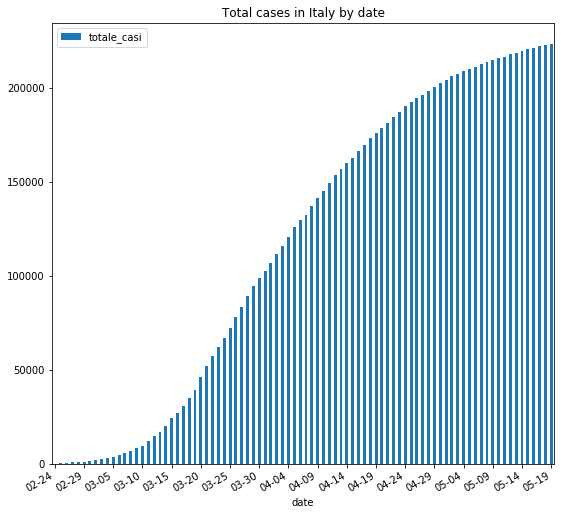

In [247]:
# plotting a graph showing day by day the number of total cases in Italy

# changing the dates for better readability 
# E.g. from the date '2020-05-17' the part involving the year is removed, leaving '05-17' as date
total_cases_by_date.rename(index=lambda s: s[5:], inplace=True)

ax = total_cases_by_date.plot(lw=2, title="Total cases in Italy by date", kind="bar")
ax.set_xlabel("date")

# sampling the dates on the ticks labels (printing a date label every 5 days)
xticks = ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)

# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

TODO eventualmente trarre qualche conclusione sull'aspetto della curva.. è richiesto?

Another data that can be single out from the provinces data, is the number of cases in each province up to this moment.
For each province is located the max value of <code>totale_casi</code>, that is the number of cases in that province, up to now.

With no surprises the maximum number in the total cases in each province is from the last date available, since the number of <code>totale_casi</code>, is incremented each day. 

In [248]:
max_cases_per_province = refined_province_data.drop(columns=["lat", "long"]).groupby(['sigla_provincia']).max()
max_cases_per_province.head()

,data,denominazione_provincia,denominazione_regione,totale_casi
sigla_provincia,,,,
AG,2020-05-19,Agrigento,Sicilia,141
AL,2020-05-19,Alessandria,Piemonte,3807
AN,2020-05-19,Ancona,Marche,1867
AO,2020-05-19,Aosta,Valle d'Aosta,1175
AP,2020-05-19,Ascoli Piceno,Marche,290


As done before, a result obtained in a table can be presented with a graph. In order to keep simple the appearence of the graph, and avoid it to become excessively messy, only the top 15 provinces with most cases are shown. 

Text(0.5, 1.0, 'Top 15 provinces with most cases')

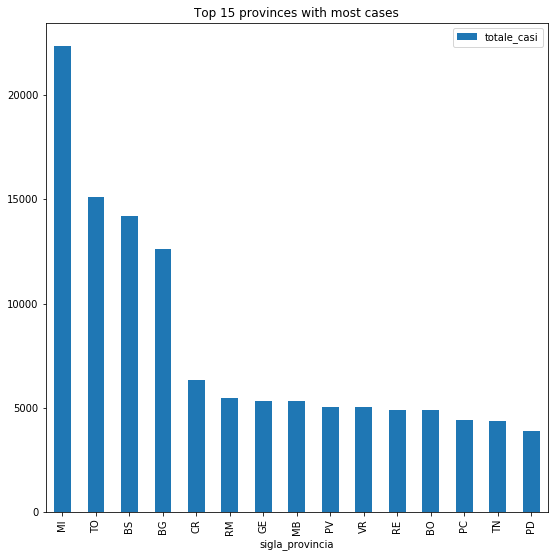

In [249]:
# Showing the top 15 provinces with the highest value on 'totale_casi'

max_cases_per_province.groupby(['sigla_provincia']).max().nlargest(15, 'totale_casi').plot(kind="bar")
plt.title("Top 15 provinces with most cases")

TODO: fixed 'till this point

In [250]:
data = []
for province in covid19_provinces_data:
    province_denomination = province['sigla_provincia']
    province_date = province['data']
    # Es. ('FI', '2020-02-24T...', all data on that row)
    # the first 2 values will be used as key
    data.append([province_denomination, province_date, province.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
province_info = []
for province in data:
    index.append([province[0], province[1]]) # (Name, date)
    province_info.append(province[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
dati = pd.DataFrame(province_info, index=index, columns=covid19_provinces_data[0].keys())
# and drop some usless columns
dati = dati.drop(columns=['codice_regione', 'denominazione_provincia', 'stato', 'codice_provincia', 'note_it', 'note_en'])
dati

data  denominazione_regione  \
   2020-02-24T18:00:00  2020-02-24T18:00:00                Abruzzo   
   2020-02-24T18:00:00  2020-02-24T18:00:00             Basilicata   
   2020-02-24T18:00:00  2020-02-24T18:00:00           P.A. Bolzano   
   2020-02-24T18:00:00  2020-02-24T18:00:00               Calabria   
   2020-02-24T18:00:00  2020-02-24T18:00:00               Campania   
   2020-02-24T18:00:00  2020-02-24T18:00:00         Emilia-Romagna   
   2020-02-24T18:00:00  2020-02-24T18:00:00  Friuli Venezia Giulia   
   2020-02-24T18:00:00  2020-02-24T18:00:00                  Lazio   
   2020-02-24T18:00:00  2020-02-24T18:00:00                Liguria   
   2020-02-24T18:00:00  2020-02-24T18:00:00              Lombardia   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Marche   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Molise   
   2020-02-24T18:00:00  2020-02-24T18:00:00               Piemonte   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Puglia   
   2020-02-24T18:00:00  2020-02-24T18:00:00               Sardegna   
   2020-02-24T18:00:00  2020-02-24T18:00:00                Sicilia   
   2020-02-24T18:00:00  2020-02-24T18:00:00                Toscana   
   2020-02-24T18:00:00  2020-02-24T18:00:00            P.A. Trento   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Umbria   
   2020-02-24T18:00:00  2020-02-24T18:00:00          Valle d'Aosta   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Veneto   
   2020-02-25T18:00:00  2020-02-25T18:00:00                Abruzzo   
   2020-02-25T18:00:00  2020-02-25T18:00:00             Basilicata   
   2020-02-25T18:00:00  2020-02-25T18:00:00           P.A. Bolzano   
   2020-02-25T18:00:00  2020-02-25T18:00:00               Calabria   
   2020-02-25T18:00:00  2020-02-25T18:00:00               Campania   
   2020-02-25T18:00:00  2020-02-25T18:00:00         Emilia-Romagna   
   2020-02-25T18:00:00  2020-02-25T18:00:00  Friuli Venezia Giulia   
   2020-02-25T18:00:00  2020-02-25T18:00:00                  Lazio   
   2020-02-25T18:00:00  2020-02-25T18:00:00                Liguria   
...                                     ...                    ...   
VV 2020-04-20T17:00:00  2020-04-20T17:00:00               Calabria   
   2020-04-21T17:00:00  2020-04-21T17:00:00               Calabria   
   2020-04-22T17:00:00  2020-04-22T17:00:00               Calabria   
   2020-04-23T17:00:00  2020-04-23T17:00:00               Calabria   
   2020-04-24T17:00:00  2020-04-24T17:00:00               Calabria   
   2020-04-25T17:00:00  2020-04-25T17:00:00               Calabria   
   2020-04-26T17:00:00  2020-04-26T17:00:00               Calabria   
   2020-04-27T17:00:00  2020-04-27T17:00:00               Calabria   
   2020-04-28T17:00:00  2020-04-28T17:00:00               Calabria   
   2020-04-29T17:00:00  2020-04-29T17:00:00               Calabria   
   2020-04-30T17:00:00  2020-04-30T17:00:00               Calabria   
   2020-05-01T17:00:00  2020-05-01T17:00:00               Calabria   
   2020-05-02T17:00:00  2020-05-02T17:00:00               Calabria   
   2020-05-03T17:00:00  2020-05-03T17:00:00               Calabria   
   2020-05-04T17:00:00  2020-05-04T17:00:00               Calabria   
   2020-05-05T17:00:00  2020-05-05T17:00:00               Calabria   
   2020-05-06T17:00:00  2020-05-06T17:00:00               Calabria   
   2020-05-07T17:00:00  2020-05-07T17:00:00               Calabria   
   2020-05-08T17:00:00  2020-05-08T17:00:00               Calabria   
   2020-05-09T17:00:00  2020-05-09T17:00:00               Calabria   
   2020-05-10T17:00:00  2020-05-10T17:00:00               Calabria   
   2020-05-11T17:00:00  2020-05-11T17:00:00               Calabria   
   2020-05-12T17:00:00  2020-05-12T17:00:00               Calabria   
   2020-05-13T17:00:00  2020-05-13T17:00:00               Calabria   
   2020-05-14T17:00:00  2020-05-14T17:00:00               Calabria   
   2020-05-15T17:00:00  2020-05-15T17:00:00      

In [251]:
# TODO raggruppo con fuori provincia e dentro data e tiro fuori per ciascuna provincia il numero di malati sommando,
# in totale

# Get the provinces name (Sigle)
provinces = dati.sigla_provincia.unique()
# Create a DataFrame with total cases per month for each province
cases_per_month = {}

for province in provinces: 
    province_info = dati.loc[province]
    # The 'groupby(province_info.data.str[:7]' is used to group the rows according to the month
    # The [:7] is used to slice the first t letters of the 'data' column
    # 2020-05-15T17:00:00 ---> 2020-05
    # And finally sum the 'totale_casi' values grouped by month for each province
    cases_per_month[province] = pd.Series(province_info.groupby(province_info.data.str[:7])['totale_casi'].sum())

# Create the DataFrame using the Series defined in the for loop
cpm = pd.DataFrame(cases_per_month)
cpm.index.name = "" # Works fine even without this line, but there was an empty line that was bothering me
cpm = cpm.T # For a better view
cpm

,2020-02,2020-03,2020-04,2020-05
,198,39032,86204,60379
AG,0,878,3697,2615
AL,0,14258,74646,70245
AN,0,12655,47962,34855
AO,0,6155,28725,21967
AP,0,1465,7714,5445
AQ,0,961,6467,4634
AR,0,3291,14922,12551
AT,0,4462,29074,31891
AV,0,2381,12028,9372


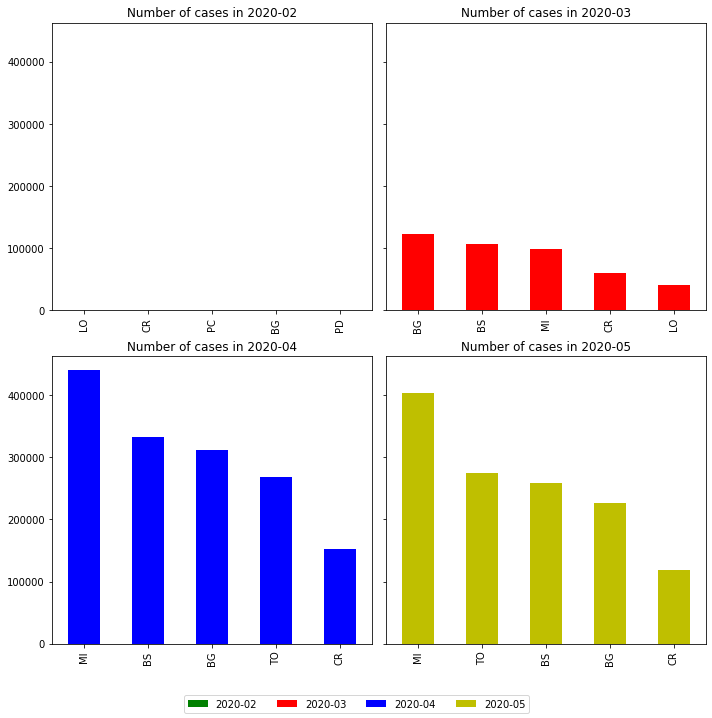

In [252]:
grid_size = (2,2) # For the 4 month considered
colors = ['g', 'r', 'b', 'y']
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharey=True, figsize=(10,10))
cities_with_worst_cases = [] # Store the name of the cities with the worst cases

month = 0
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        # Cities twith the worst cases in the current month
        worst_cases = cpm.nlargest(5, cpm.columns[month])[cpm.columns[month]]
        worst_cases.plot(ax=axes[i,j], kind='bar', legend=False, color=colors[month])
        axes[i, j].set_title('Number of cases in '+cpm.columns[month]) # Doesn't work
        cities_with_worst_cases.append(worst_cases)
        month += 1
        
fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=cpm.columns, loc="lower center", ncol=4)

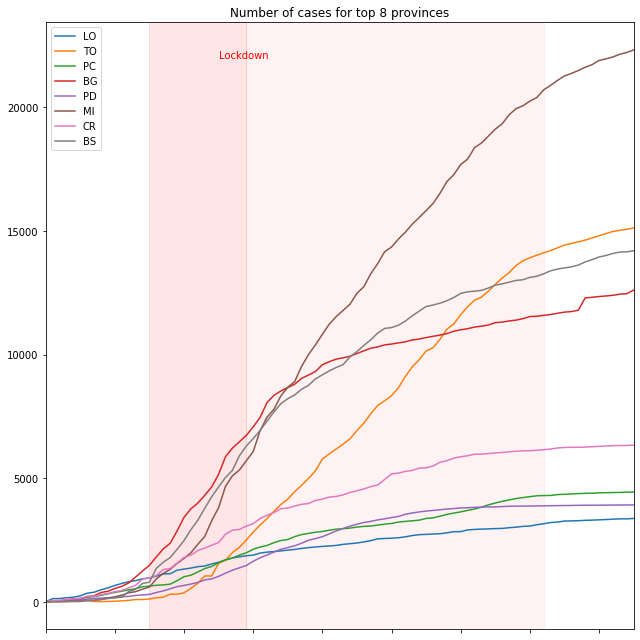

In [253]:
# Create a set of the cities with the worst case 
interested_city = list(set([item for sublist in [list(city.index) for city in cities_with_worst_cases] for item in sublist]))


# Collect information about these cities day by day
for i in range(len(interested_city)):
    dati.loc[interested_city[i]]['totale_casi'].plot(
        kind='line', 
        label=interested_city[i], 
        title="Number of cases for top 8 provinces").set_xticklabels([])
    #plt.plot(list(range(len(case_per_day))), case_per_day, label=interested_city[i], title="wooo")
    

plt.text(25, 22000, "Lockdown", color="r")
plt.axvspan(15, 29, color='red', alpha=0.1)
plt.axvspan(29, 72, color='red', alpha=0.05)
plt.tight_layout()
plt.legend()


In [254]:
data = []
for region in covid19_regions_data:
    region_denomination = region['denominazione_regione']
    region_date = region['data']
    data.append([region_denomination, region_date, region.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
region_info = []
for region in data:
    index.append([region[0], region[1]]) # (Name, date)
    region_info.append(region[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
regions_data_frame = pd.DataFrame(region_info, index=index, columns=covid19_regions_data[0].keys()).fillna(0)
regions_data_frame = regions_data_frame.drop(columns=['data', 'codice_regione', 'denominazione_regione', 'stato', 'note_it', 'note_en', 'lat', 'long'])
regions_data_frame

ricoverati_con_sintomi  terapia_intensiva  \
Abruzzo 2020-02-24T18:00:00                       0                  0   
        2020-02-25T18:00:00                       0                  0   
        2020-02-26T18:00:00                       0                  0   
        2020-02-27T18:00:00                       1                  0   
        2020-02-28T18:00:00                       1                  0   
        2020-02-29T17:00:00                       2                  0   
        2020-03-01T17:00:00                       3                  0   
        2020-03-02T18:00:00                       3                  0   
        2020-03-03T18:00:00                       5                  0   
        2020-03-04T17:00:00                       7                  0   
        2020-03-05T17:00:00                       8                  0   
        2020-03-06T17:00:00                       9                  0   
        2020-03-07T18:00:00                      11                  0   
        2020-03-08T18:00:00                      14                  0   
        2020-03-09T18:00:00                      25                  0   
        2020-03-10T18:00:00                      17                  9   
        2020-03-11T17:00:00                      17                  9   
        2020-03-12T17:00:00                      47                 12   
        2020-03-13T17:00:00                      42                 14   
        2020-03-14T17:00:00                      51                 14   
        2020-03-15T17:00:00                      72                 28   
        2020-03-16T17:00:00                      71                 37   
        2020-03-17T17:00:00                      94                 32   
        2020-03-18T17:00:00                      99                 41   
        2020-03-19T17:00:00                     181                 47   
        2020-03-20T17:00:00                     190                 48   
        2020-03-21T17:00:00                     185                 44   
        2020-03-22T17:00:00                     218                 49   
        2020-03-23T17:00:00                     228                 52   
        2020-03-24T17:00:00                     234                 57   
...                                             ...                ...   
Veneto  2020-04-20T17:00:00                    1273                180   
        2020-04-21T17:00:00                    1230                177   
        2020-04-22T17:00:00                    1205                163   
        2020-04-23T17:00:00                    1189                140   
        2020-04-24T17:00:00                    1159                130   
        2020-04-25T17:00:00                    1105                129   
        2020-04-26T17:00:00                    1097                124   
        2020-04-27T17:00:00                    1099                123   
        2020-04-28T17:00:00                    1067                120   
        2020-04-29T17:00:00                    1042                114   
        2020-04-30T17:00:00                    1012                114   
        2020-05-01T17:00:00                     977                110   
        2020-05-02T17:00:00                     970                108   
        2020-05-03T17:00:00                     955                103   
        2020-05-04T17:00:00                     955                101   
        2020-05-05T17:00:00                     926                 98   
        2020-05-06T17:00:00                     902                 90   
        2020-05-07T17:00:00                     872                 87   
        2020-05-08T17:00:00                     831                 79   
        2020-05-09T17:00:00                     435                 40   
        2020-05-10T17:00:00                     408                 37   
        2020-05-11T17:00:00                     400                 38   
        2020-05-12T17:00:00      

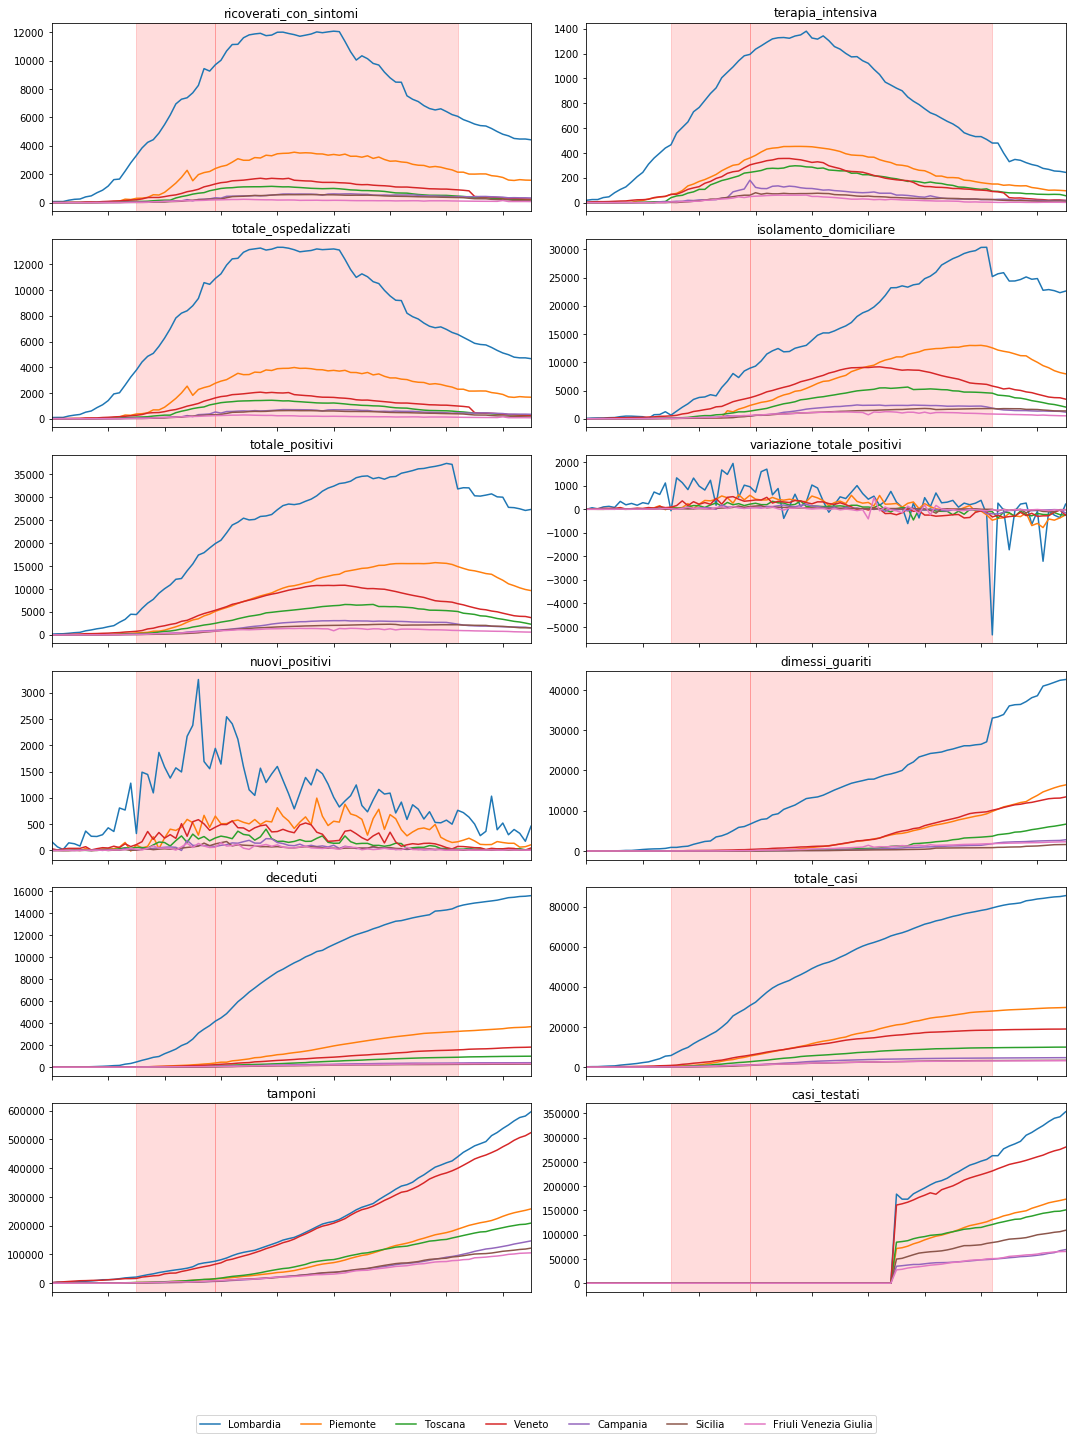

In [255]:
regions_considered = ['Lombardia', 'Piemonte', 'Toscana', 'Veneto', 'Campania', 'Sicilia', 'Friuli Venezia Giulia']
grid_size = (6, 2) # (#regions x #columns's info)
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharex=True, figsize=(15,20))

i = 0
r, c = (0,0)
for column_info in regions_data_frame.columns:
    for region in regions_considered:
        regions_data_frame.loc[region][column_info].plot(ax=axes[r,c], kind='line', title=column_info)
        axes[r,c].axvspan(29, 72, color='red', alpha=0.02)
        axes[r,c].axvspan(15, 29, color='red', alpha=0.02)
        axes[r,c].set_xticklabels([])
    
    c = (c+1)%grid_size[1]
    if c == 0:
        r+=1
#a.plot(kind='line', legend=True)
#plt.ylabel("intensive care")
#ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=regions_considered, loc="lower center", ncol=len(regions_considered))

In [256]:
data = []
for province in covid19_provinces_data:
    province_denomination = province['sigla_provincia']
    province_date = province['data']
    # Es. ('FI', '2020-02-24T...', all data on that row)
    # the first 2 values will be used as key
    data.append([province_denomination, province_date, province.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
province_info = []
for province in data:
    index.append([province[0], province[1]]) # (Name, date)
    province_info.append(province[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
data = pd.DataFrame(province_info, index=index, columns=covid19_provinces_data[0].keys())
# and drop some usless columns
density_data = data.drop(columns=['data', 'codice_regione', 'denominazione_regione', 'stato', 'codice_provincia', 'sigla_provincia', 'note_it', 'note_en'])
density_data = density_data[density_data.denominazione_provincia != "In fase di definizione/aggiornamento"]
dati = density_data.drop(columns=['long', 'lat'])
density_data.head()

denominazione_provincia        lat       long  \
AG 2020-02-24T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-25T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-26T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-27T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-28T18:00:00               Agrigento  37.309711  13.584575   

                        totale_casi  
AG 2020-02-24T18:00:00            0  
   2020-02-25T18:00:00            0  
   2020-02-26T18:00:00            0  
   2020-02-27T18:00:00            0  
   2020-02-28T18:00:00            0

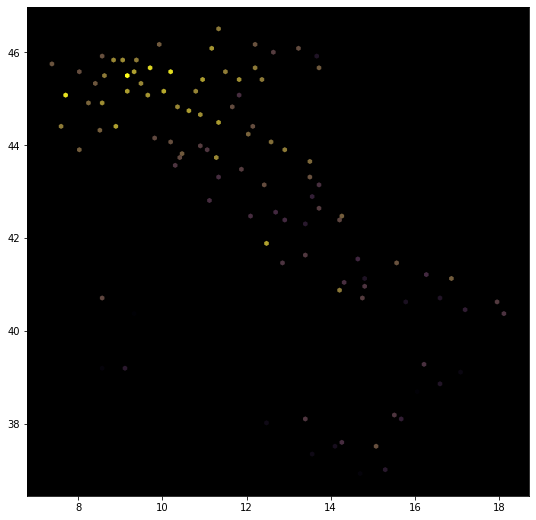

In [257]:
from matplotlib.colors import LinearSegmentedColormap

tmp = []
for i in density_data.index.unique(level=0):
    tmp.append(density_data.loc[i].iloc[-1])
df = pd.DataFrame(tmp)
x = df['long']
y = df['lat']
z = df['totale_casi']

red = ((0., 0., 0.),
         (.3, .5, 0.5),
         (1., 1., 1.))
blue = ((0., .2, .2),
         (.3, .5, .5),
         (.8, .2, .2),
         (1., .1, .1))
green = ((0,1,0),(1,1,0))


cdict3 = {'red':  red,
     'green': green,
     'blue': blue,
     'alpha': ((0.0, 0.0, 0.0),
               (0.3, 0.5, 0.5),
               (1.0, 1.0, 1.0))
    }

dropout_high = LinearSegmentedColormap('Dropout', cdict3)
plt.register_cmap(cmap = dropout_high)

ax = plt.gca()
ax.set_facecolor('black')

plt.hexbin(x,y, C=z, bins='log', cmap=dropout_high, edgecolors=None)

In [258]:
# set the filepath and load in a shapefile
fp = "shape-italy/ITA_adm1.shp"
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.drop(columns=["VARNAME_1", "TYPE_1", "ID_1", "ENGTYPE_1", "NL_NAME_1", "ISO", "ID_0", "NAME_0"])

,NAME_1,geometry
0,Abruzzo,"POLYGON ((13.91542 42.89561, 13.91542 42.89542..."
1,Apulia,"MULTIPOLYGON (((17.94931 40.05375, 17.94931 40..."
2,Basilicata,"MULTIPOLYGON (((15.71736 39.96792, 15.71736 39..."
3,Calabria,"MULTIPOLYGON (((15.80208 39.70014, 15.80208 39..."
4,Campania,"MULTIPOLYGON (((14.25264 40.54153, 14.25264 40..."
5,Emilia-Romagna,"MULTIPOLYGON (((12.40590 43.89975, 12.40600 43..."
6,Friuli-Venezia Giulia,"MULTIPOLYGON (((13.31625 45.69347, 13.31625 45..."
7,Lazio,"MULTIPOLYGON (((13.45514 40.79264, 13.45514 40..."
8,Liguria,"MULTIPOLYGON (((8.22597 44.02736, 8.22597 44.0..."
9,Lombardia,"MULTIPOLYGON (((8.81457 45.01818, 8.81401 45.0..."


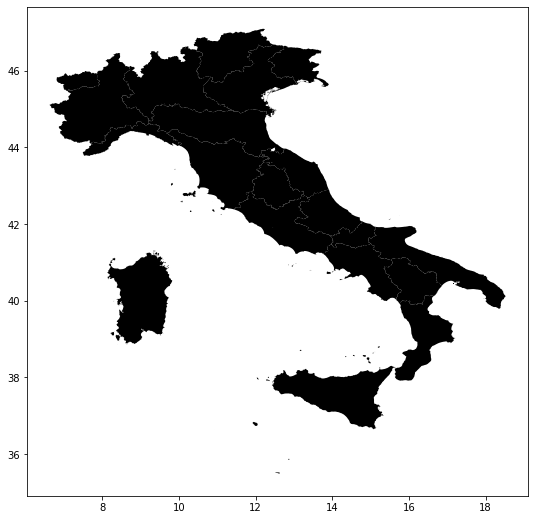

In [259]:
plt.rcParams['figure.figsize'] = [9, 9] #height, width
plt.rcParams['patch.facecolor'] = 'black'
map_df.plot()

In [260]:
# prendiamo la tabella originale e impostiamo crs, definisci cos'è coordinate reference system
crs = CRS("epsg:4326")
refined_province_data.head()

,data,denominazione_provincia,denominazione_regione,lat,long,sigla_provincia,totale_casi
0,2020-02-24,Chieti,Abruzzo,42.351032,14.167546,CH,0
1,2020-02-24,L'Aquila,Abruzzo,42.351222,13.398438,AQ,0
2,2020-02-24,Pescara,Abruzzo,42.464584,14.213648,PE,0
3,2020-02-24,Teramo,Abruzzo,42.658918,13.704400,TE,0
5,2020-02-24,Matera,Basilicata,40.667512,16.597924,MT,0


In [261]:
# extract latitude and longitude data from the last date available, along with the total cases (that are at its max)
# lasciata la colonna data in vista di uno stesso calcolo ma diviso per mesi e non prendendo il numero massimo di casi
provinces_data_per_latitude_longitude = refined_province_data.drop(columns=["denominazione_regione", "sigla_provincia"]).groupby(["denominazione_provincia"]).max()
provinces_data_per_latitude_longitude.head()

,data,lat,long,totale_casi
denominazione_provincia,,,,
Agrigento,2020-05-19,37.309711,13.584575,141
Alessandria,2020-05-19,44.912974,8.615401,3807
Ancona,2020-05-19,43.616760,13.518875,1867
Aosta,2020-05-19,45.737503,7.320149,1175
Arezzo,2020-05-19,43.466428,11.882288,674


In [262]:
geometry = [Point(xy) for xy in zip(provinces_data_per_latitude_longitude['long'], provinces_data_per_latitude_longitude['lat'])]
# plotting some points
geometry[:3]


In [263]:
# now we can create our GeoDataFrame using this points
geo_df= gpd.GeoDataFrame(provinces_data_per_latitude_longitude, crs = crs, geometry = geometry)
geo_df.head()

,data,lat,long,totale_casi,geometry
denominazione_provincia,,,,,
Agrigento,2020-05-19,37.309711,13.584575,141,POINT (13.58457 37.30971)
Alessandria,2020-05-19,44.912974,8.615401,3807,POINT (8.61540 44.91297)
Ancona,2020-05-19,43.616760,13.518875,1867,POINT (13.51888 43.61676)
Aosta,2020-05-19,45.737503,7.320149,1175,POINT (7.32015 45.73750)
Arezzo,2020-05-19,43.466428,11.882288,674,POINT (11.88229 43.46643)


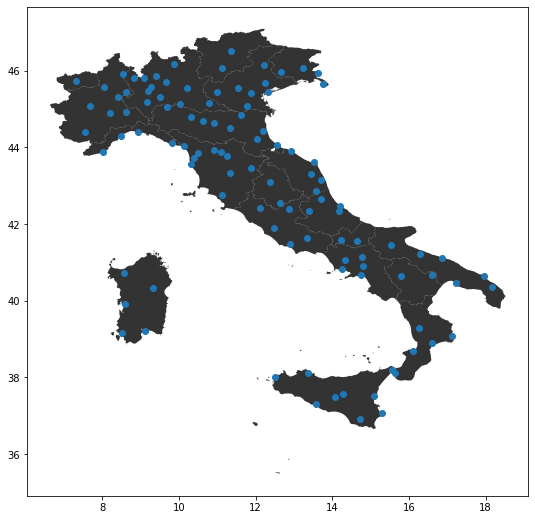

In [264]:
fig,ax= plt.subplots(figsize=(9,9))
map_df.plot(ax=ax, alpha=0.8, color="black")
geo_df.plot(ax=ax)

In [265]:
# extract latitude and longitude data from the last date available, along with the total cases (that are at its max)
# lasciata la colonna data in vista di uno stesso calcolo ma diviso per mesi e non prendendo il numero massimo di casi
provinces_data_per_latitude_longitude = refined_province_data.drop(columns=["denominazione_regione", "sigla_provincia"]).groupby(["denominazione_provincia"]).max()
provinces_data_per_latitude_longitude.head()

,data,lat,long,totale_casi
denominazione_provincia,,,,
Agrigento,2020-05-19,37.309711,13.584575,141
Alessandria,2020-05-19,44.912974,8.615401,3807
Ancona,2020-05-19,43.616760,13.518875,1867
Aosta,2020-05-19,45.737503,7.320149,1175
Arezzo,2020-05-19,43.466428,11.882288,674


In [266]:
geometry = [Point(xy) for xy in zip(provinces_data_per_latitude_longitude['long'], provinces_data_per_latitude_longitude['lat'])]
# plotting some points
geometry[:3]


In [267]:
# now we can create our GeoDataFrame using this points
geo_df= gpd.GeoDataFrame(provinces_data_per_latitude_longitude, crs = crs, geometry = geometry)
geo_df.head()

,data,lat,long,totale_casi,geometry
denominazione_provincia,,,,,
Agrigento,2020-05-19,37.309711,13.584575,141,POINT (13.58457 37.30971)
Alessandria,2020-05-19,44.912974,8.615401,3807,POINT (8.61540 44.91297)
Ancona,2020-05-19,43.616760,13.518875,1867,POINT (13.51888 43.61676)
Aosta,2020-05-19,45.737503,7.320149,1175,POINT (7.32015 45.73750)
Arezzo,2020-05-19,43.466428,11.882288,674,POINT (11.88229 43.46643)


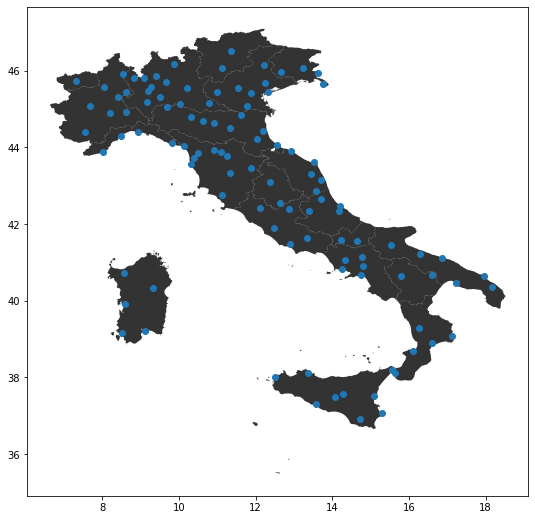

In [268]:
fig,ax= plt.subplots(figsize=(9,9))
map_df.plot(ax=ax, alpha=0.8, color="black")
geo_df.plot(ax=ax)